Для фитнес-центра можно считать, что клиент попал в отток, если за последний месяц ни разу не посетил спортзал. Конечно, не исключено, что он уехал на Бали и по приезде обязательно продолжит ходить на фитнес. Однако чаще бывает наоборот. Если клиент начал новую жизнь с понедельника, немного походил в спортзал, а потом пропал — скорее всего, он не вернётся. Чтобы бороться с оттоком, отдел по работе с клиентами «Культуриста-датасаентиста» перевёл в электронный вид множество клиентских анкет. Ваша задача — провести анализ и подготовить план действий по удержанию клиентов.

А именно:

- научиться прогнозировать вероятность оттока (на уровне следующего месяца) для каждого клиента;

- сформировать типичные портреты клиентов: выделить несколько наиболее ярких групп и охарактеризовать их основные свойства;

- проанализировать основные признаки, наиболее сильно влияющие на отток;

сформулировать основные выводы и разработать рекомендации по повышению качества работы с клиентами:

1) выделить целевые группы клиентов;

2) предложить меры по снижению оттока;

3) определить другие особенности взаимодействия с клиентами.

Набор данных включает следующие поля:
- 'Churn' — факт оттока в текущем месяце;
- Текущие поля в датасете:
    - Данные клиента за предыдущий до проверки факта оттока месяц:
        - 'gender' — пол;
        - 'Near_Location' — проживание или работа в районе, где находится фитнес-центр;
        - 'Partner' — сотрудник компании-партнёра клуба (сотрудничество с компаниями, чьи сотрудники могут получать скидки на абонемент — в таком случае фитнес-центр хранит информацию о работодателе клиента);
        - Promo_friends — факт первоначальной записи в рамках акции «приведи друга» (использовал промо-код от знакомого при оплате первого абонемента);
        - 'Phone' — наличие контактного телефона;
        - 'Age' — возраст;
        - 'Lifetime' — время с момента первого обращения в фитнес-центр (в месяцах).
    - Информация на основе журнала посещений, покупок и информация о текущем статусе абонемента клиента:
        - 'Contract_period' — длительность текущего действующего абонемента (месяц, 3 месяца, 6 месяцев, год);
        - 'Month_to_end_contract' — срок до окончания текущего действующего абонемента (в месяцах);
        - 'Group_visits' — факт посещения групповых занятий;
        - 'Avg_class_frequency_total' — средняя частота посещений в неделю за все время с начала действия абонемента;
        - 'Avg_class_frequency_current_month' — средняя частота посещений в неделю за предыдущий месяц;
        - 'Avg_additional_charges_total' — суммарная выручка от других услуг фитнес-центра: кафе, спорт-товары, косметический и массажный салон.

In [7]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.cluster import KMeans
from sklearn.metrics import confusion_matrix
import warnings

In [45]:
warnings.filterwarnings('ignore')

## Шаг 1. Загрузите данные

In [30]:
df = pd.read_csv('/content/drive/MyDrive/praktikum/gum_churn/gym_churn (1).csv')

In [31]:
df.head()

,gender,Near_Location,Partner,Promo_friends,Phone,Contract_period,Group_visits,Age,Avg_additional_charges_total,Month_to_end_contract,Lifetime,Avg_class_frequency_total,Avg_class_frequency_current_month,Churn
0,1,1,1,1,0,6,1,29,14.227470,5.0,3,0.020398,0.000000,0
1,0,1,0,0,1,12,1,31,113.202938,12.0,7,1.922936,1.910244,0
2,0,1,1,0,1,1,0,28,129.448479,1.0,2,1.859098,1.736502,0
3,0,1,1,1,1,12,1,33,62.669863,12.0,2,3.205633,3.357215,0
4,1,1,1,1,1,1,0,26,198.362265,1.0,3,1.113884,1.120078,0


In [32]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 14 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   gender                             4000 non-null   int64  
 1   Near_Location                      4000 non-null   int64  
 2   Partner                            4000 non-null   int64  
 3   Promo_friends                      4000 non-null   int64  
 4   Phone                              4000 non-null   int64  
 5   Contract_period                    4000 non-null   int64  
 6   Group_visits                       4000 non-null   int64  
 7   Age                                4000 non-null   int64  
 8   Avg_additional_charges_total       4000 non-null   float64
 9   Month_to_end_contract              4000 non-null   float64
 10  Lifetime                           4000 non-null   int64  
 11  Avg_class_frequency_total          4000 non-null   float

In [36]:
#Посмотрим на наличие полных дубликатов
df.duplicated().sum()

0

In [37]:
df.isna().sum()

gender                               0
Near_Location                        0
Partner                              0
Promo_friends                        0
Phone                                0
Contract_period                      0
Group_visits                         0
Age                                  0
Avg_additional_charges_total         0
Month_to_end_contract                0
Lifetime                             0
Avg_class_frequency_total            0
Avg_class_frequency_current_month    0
Churn                                0
dtype: int64

In [38]:
df.isnull().sum()

gender                               0
Near_Location                        0
Partner                              0
Promo_friends                        0
Phone                                0
Contract_period                      0
Group_visits                         0
Age                                  0
Avg_additional_charges_total         0
Month_to_end_contract                0
Lifetime                             0
Avg_class_frequency_total            0
Avg_class_frequency_current_month    0
Churn                                0
dtype: int64

In [39]:
#Для удобства приведем все названия столбцов к нижнему регистру
df.columns = df.columns.str.lower()

In [40]:
#посмотрим на данные в каждом из столбцов
for i in df.columns:
    print('Кол-во уникальных ', i, ':',df[i].duplicated().sum())
    display(df[i].value_counts(dropna=False))
    print('-' * 50)

Кол-во уникальных  gender : 3998


1    2041
0    1959
Name: gender, dtype: int64

--------------------------------------------------
Кол-во уникальных  near_location : 3998


1    3381
0     619
Name: near_location, dtype: int64

--------------------------------------------------
Кол-во уникальных  partner : 3998


0    2053
1    1947
Name: partner, dtype: int64

--------------------------------------------------
Кол-во уникальных  promo_friends : 3998


0    2766
1    1234
Name: promo_friends, dtype: int64

--------------------------------------------------
Кол-во уникальных  phone : 3998


1    3614
0     386
Name: phone, dtype: int64

--------------------------------------------------
Кол-во уникальных  contract_period : 3997


1     2207
12     960
6      833
Name: contract_period, dtype: int64

--------------------------------------------------
Кол-во уникальных  group_visits : 3998


0    2351
1    1649
Name: group_visits, dtype: int64

--------------------------------------------------
Кол-во уникальных  age : 3977


29    468
30    457
28    447
31    434
27    378
32    364
26    300
33    253
25    231
34    174
24    148
35     98
23     82
36     48
22     33
37     29
21     24
20     14
38     10
39      3
19      2
18      2
41      1
Name: age, dtype: int64

--------------------------------------------------
Кол-во уникальных  avg_additional_charges_total : 0


221.999512    1
110.231712    1
190.703690    1
457.406464    1
71.351463     1
             ..
103.496689    1
59.337753     1
137.840225    1
139.349518    1
128.000092    1
Name: avg_additional_charges_total, Length: 4000, dtype: int64

--------------------------------------------------
Кол-во уникальных  month_to_end_contract : 3988


1.0     2207
6.0      645
12.0     524
11.0     181
5.0      130
10.0      82
9.0       73
4.0       58
8.0       38
7.0       25
3.0       23
2.0       14
Name: month_to_end_contract, dtype: int64

--------------------------------------------------
Кол-во уникальных  lifetime : 3971


1     843
2     610
3     490
0     487
4     383
5     273
6     220
7     167
8     111
9     100
10     76
12     53
11     48
13     28
14     24
15     24
16     15
17     11
19      7
20      7
18      7
21      5
24      2
22      2
26      2
23      2
29      1
27      1
31      1
Name: lifetime, dtype: int64

--------------------------------------------------
Кол-во уникальных  avg_class_frequency_total : 87


0.000000    88
1.474051     1
2.104331     1
2.198065     1
1.530367     1
            ..
3.680794     1
1.470719     1
1.635516     1
2.093533     1
1.007948     1
Name: avg_class_frequency_total, Length: 3913, dtype: int64

--------------------------------------------------
Кол-во уникальных  avg_class_frequency_current_month : 180


0.000000    181
1.052202      1
3.818110      1
3.168990      1
0.830814      1
           ... 
2.020883      1
2.083380      1
0.567718      1
2.302114      1
1.937500      1
Name: avg_class_frequency_current_month, Length: 3820, dtype: int64

--------------------------------------------------
Кол-во уникальных  churn : 3998


0    2939
1    1061
Name: churn, dtype: int64

--------------------------------------------------


Посмотрели на значения в столбцах воотчию - ничего необычного не наблюдается.

## Шаг 2. Исследовательский анализ данных (EDA)

### Отсутствующие признаки, средние значения и стандартные отклонения

In [42]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
gender,4000.0,0.510250,0.499957,0.000000,0.000000,1.000000,1.000000,1.000000
near_location,4000.0,0.845250,0.361711,0.000000,1.000000,1.000000,1.000000,1.000000
partner,4000.0,0.486750,0.499887,0.000000,0.000000,0.000000,1.000000,1.000000
promo_friends,4000.0,0.308500,0.461932,0.000000,0.000000,0.000000,1.000000,1.000000
phone,4000.0,0.903500,0.295313,0.000000,1.000000,1.000000,1.000000,1.000000
contract_period,4000.0,4.681250,4.549706,1.000000,1.000000,1.000000,6.000000,12.000000
group_visits,4000.0,0.412250,0.492301,0.000000,0.000000,0.000000,1.000000,1.000000
age,4000.0,29.184250,3.258367,18.000000,27.000000,29.000000,31.000000,41.000000
avg_additional_charges_total,4000.0,146.943649,96.355606,0.148205,68.868832,136.220161,210.949619,552.590759
month_to_end_contract,4000.0,4.322750,4.191243,1.000000,1.000000,1.000000,6.000000,12.000000


По описанию данных можно сделать предварительный вывод об "обычном" клиенте фитнес клуба:
- Это мужчина или женщина в возрасте около 29 лет
- Чаще всего живет в одном районе с клубом
- Абонемент у него сроком от 1 до 6 месяцев (только четверть клиентов имеют абонемент длительностью больше 6 месяцев)
- Фитнес посещает около 2х раз в неделю
- На доп.услуги тратит от 70 до 210 (в среднем 150)

### Cредние значения признаков в двух группах — тех, кто ушел в отток и тех, кто остался

In [43]:
churn_group = df.groupby('churn').agg('mean')
churn_group.T

churn,0,1
gender,0.510037,0.510839
near_location,0.873086,0.768143
partner,0.534195,0.355325
promo_friends,0.353522,0.183789
phone,0.903709,0.902922
contract_period,5.747193,1.728558
group_visits,0.464103,0.268615
age,29.976523,26.989632
avg_additional_charges_total,158.445709,115.082901
month_to_end_contract,5.283090,1.662583


Предварительно по средним значениям выяснилось, что:
- В отток в одинаковой степени попадают как мужчины, так и женщины
- Срок абонемента в "отвальной" группе короче
- "Отвальный" клиент чуть моложе

### Cтолбчатые гистограммы и распределения признаков для тех, кто ушёл (отток) и тех, кто остался (не попали в отток)

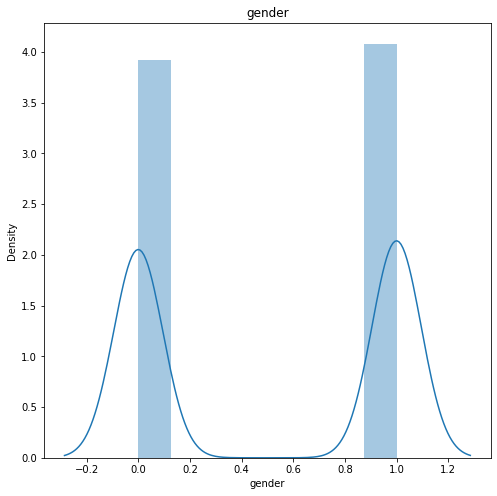

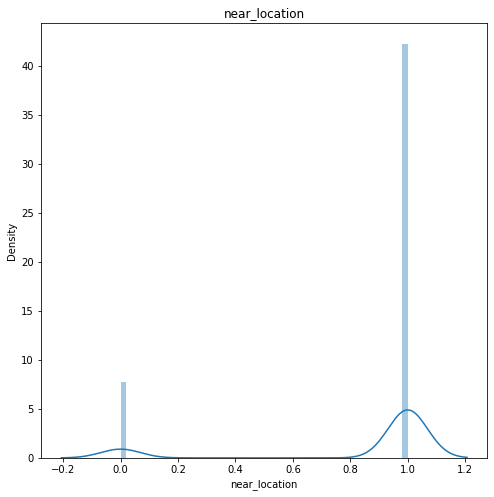

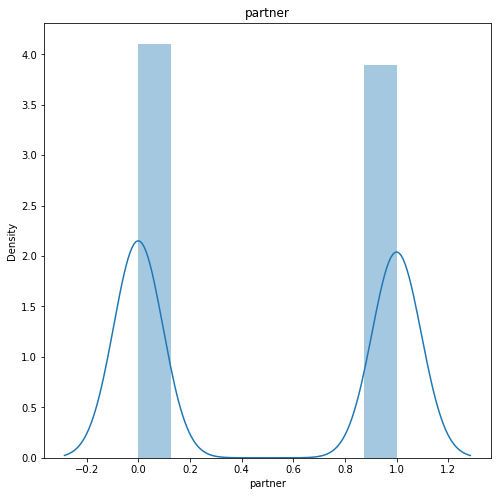

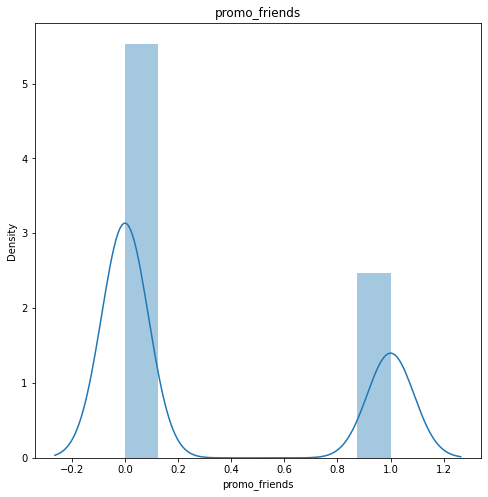

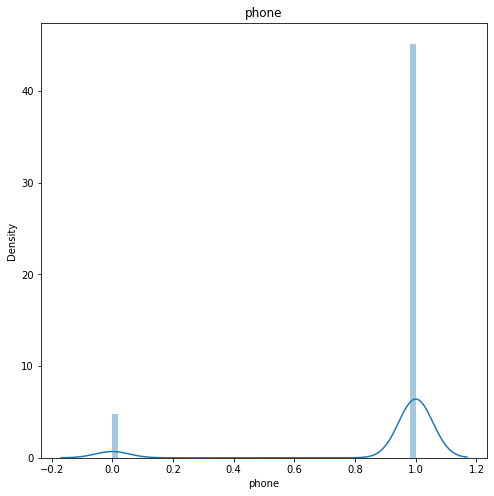

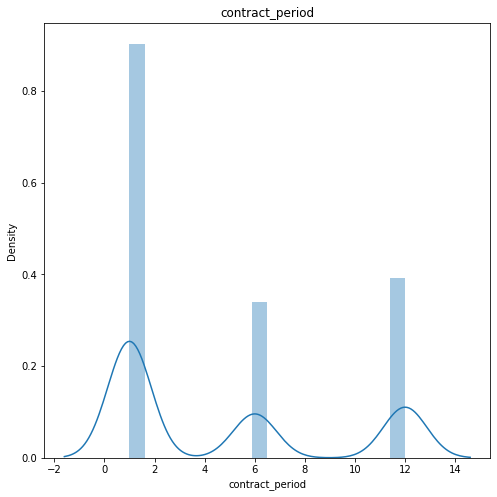

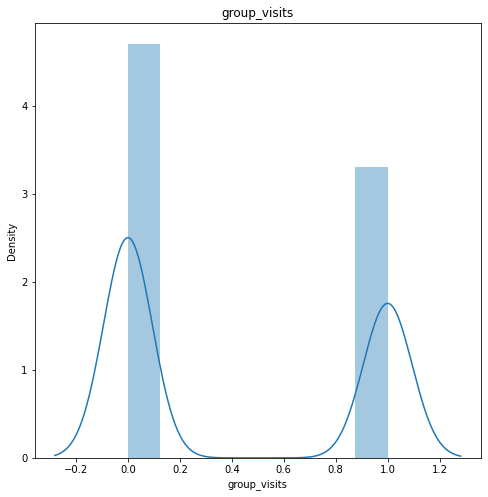

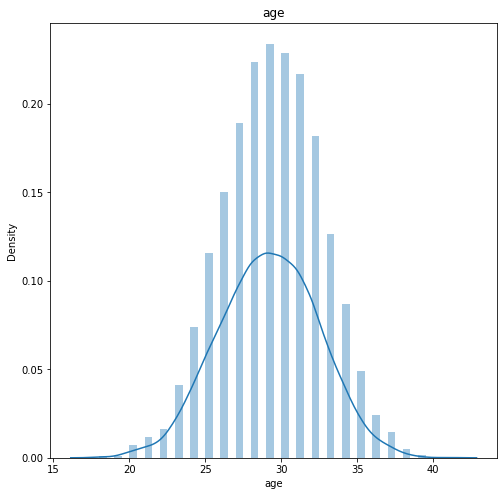

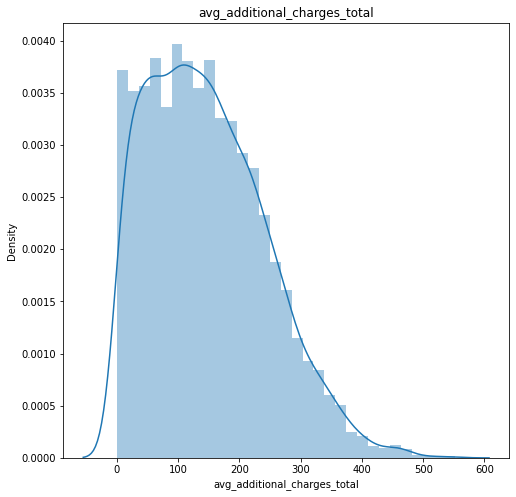

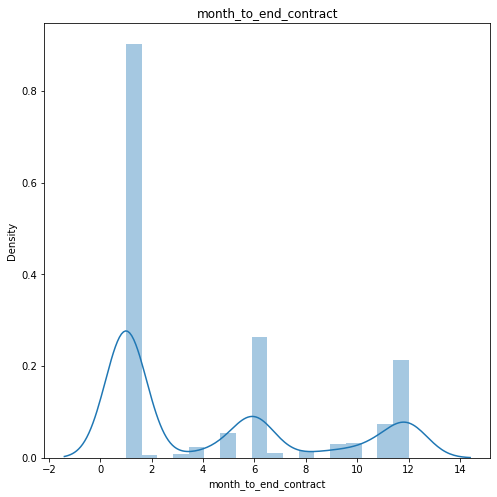

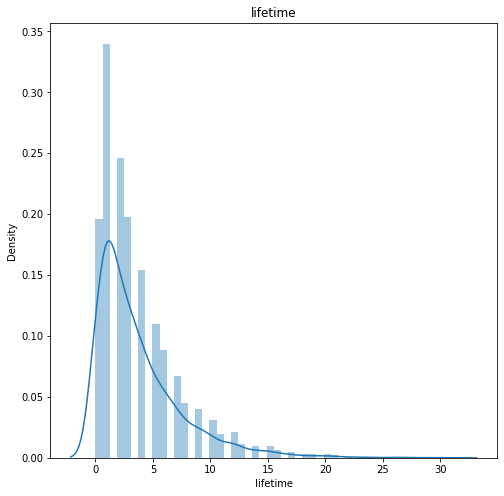

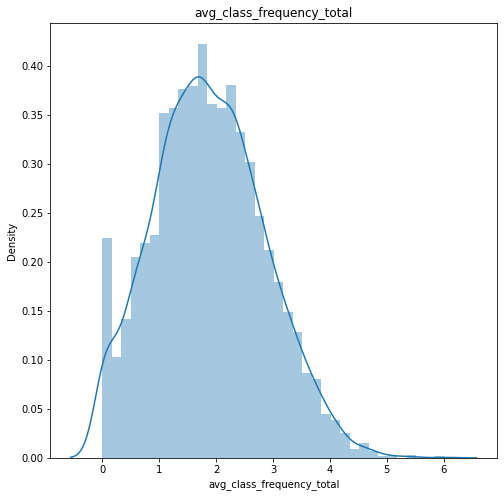

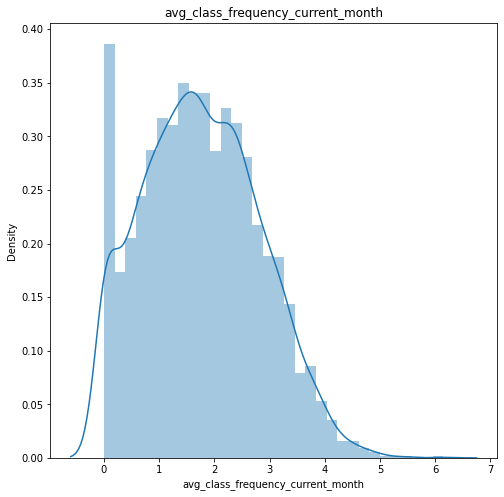

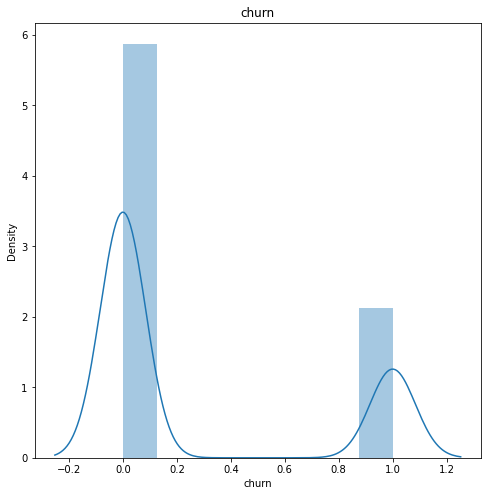

In [46]:
for column in df.columns:
    plt.figure(figsize=(8, 8))
    df.groupby('churn')[column]
    sns.distplot(df[column])
    plt.title(column)
    plt.show()

In [48]:
count_cols = ['gender', 'near_location', 'partner', 
              'promo_friends', 'phone', 'contract_period', 
              'group_visits', 'age', 'month_to_end_contract',
              'lifetime']

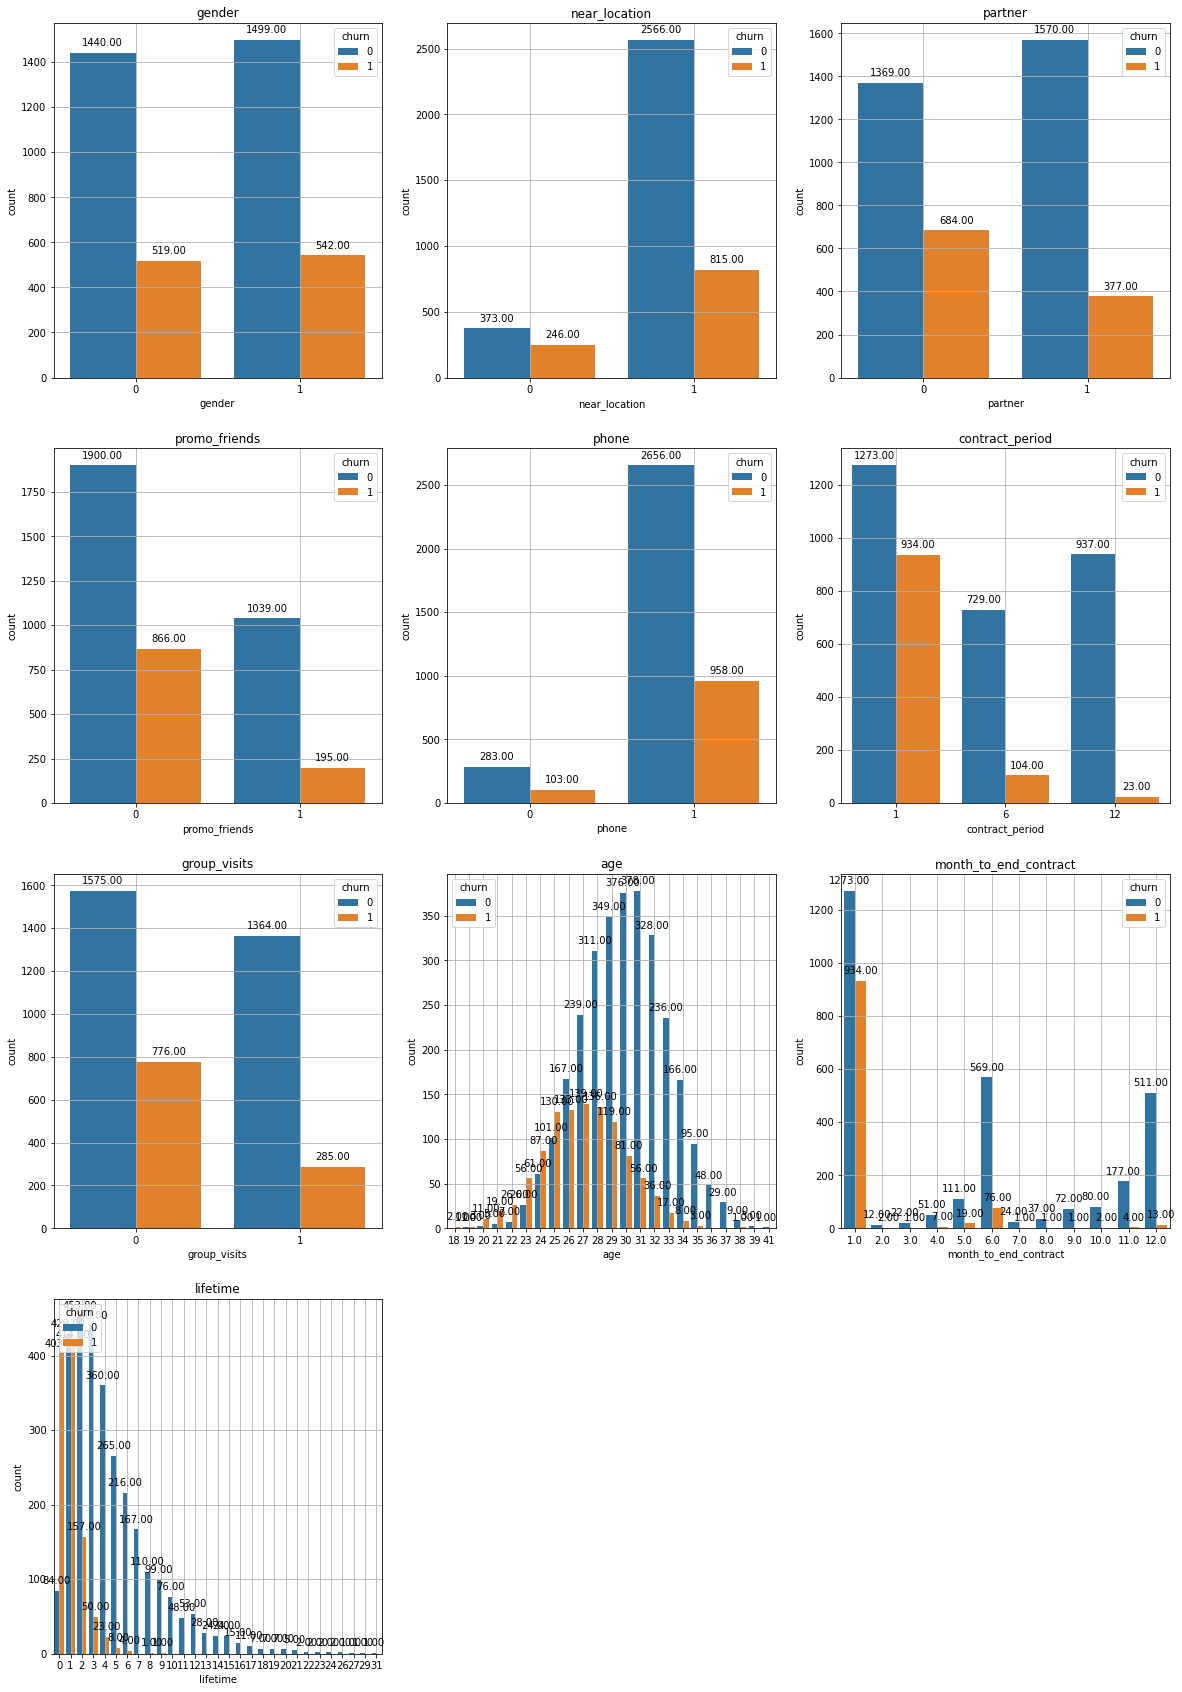

In [50]:
a = 4
b = 3
c = 1
plt.figure(figsize=(20, 30))
for column in count_cols:
    plt.subplot(a,b,c)
    plot = sns.countplot(x = df[column], hue='churn', data=df)
    plt.title(column)
    plt.grid(True)
    for p in plot.patches:
        plot.annotate(format(p.get_height(), '.2f'), 
                      (p.get_x() + p.get_width() / 2., p.get_height()), 
                      ha = 'center', va = 'center', xytext = (0, 10), 
                      textcoords = 'offset points')
    c = c+1
plt.show()

Графики показали нам, что:
- Пол клиента не влияет на отток, "отваливаются" и мужчины и женщины в одинаковой степени
- Клиенты живущие не в одном районе с фитнес-клубом чаще уходят в отток
- Клиенты фирм-партнеров реже попадают в отток
- Клиенты пришедшие по акции "приведи друга" реже попадают в отток
- Наличие контактного телефона клиента не влияет на отток, но учитывая, что клиентов без номера всего 10% было бы неплохо вообще узнать почему номер отсутствует. 
- Период действия абонемента прямо влияет на отток, клиенты с большим сроком абонемента реже уходят в отток.
- Среди посещающих групповые занятия намного меньше отваливщихся клиентов.
- Клиенты в оттоке моложе, тех кто остался. 
- В отток чаще всего попадают клиенты с абонементом на 1 месяц. 
- На ранних сроках сотрудничества чаще всего уходят в отток.

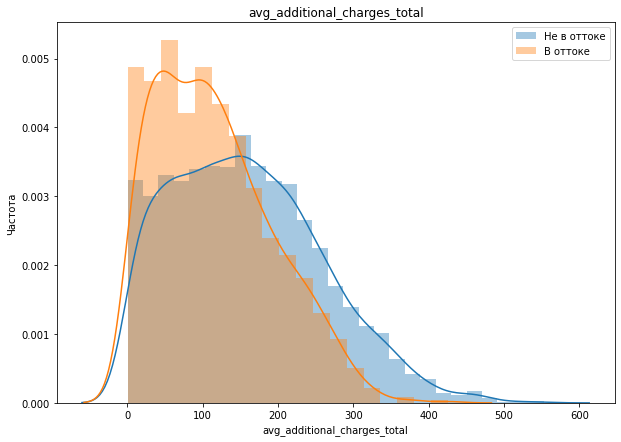

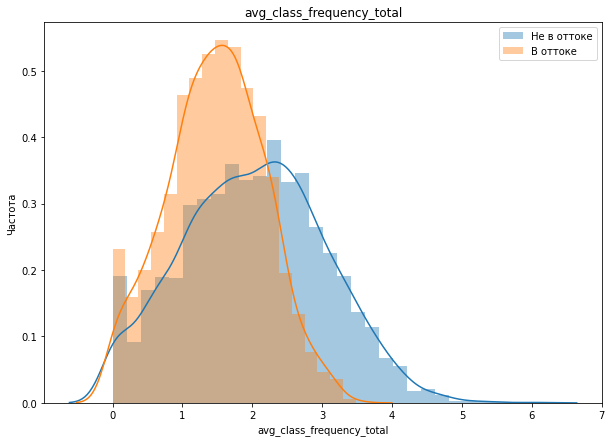

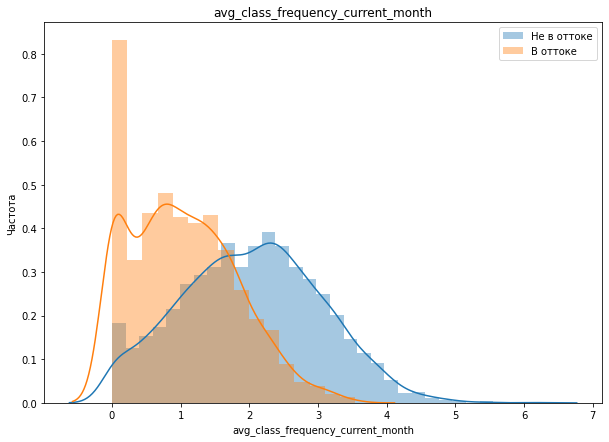

In [51]:
for col in ['avg_additional_charges_total', 'avg_class_frequency_total', 'avg_class_frequency_current_month']:
    plt.figure(figsize=(10, 7))
    sns.distplot(df.query('churn==0')[col], label='Не в оттоке')
    sns.distplot(df.query('churn==1')[col], label='В оттоке')
    plt.legend()
    plt.ylabel("Частота")
    plt.title(col)
    plt.show()

- Клиенты не в оттоке в среднем тратят больше
- Клиенты не в оттоке ходят в зал чаще (2-3 раза в неделю), в отттоке почещают фитнес 1-2 раза в неделю
- Много клиентов ушедших в отток вообще не посетили фитнес за предыдущий месяц (или можно сказать вообще не были в зале после приобретения абоненмента)

### Матрица корреляций

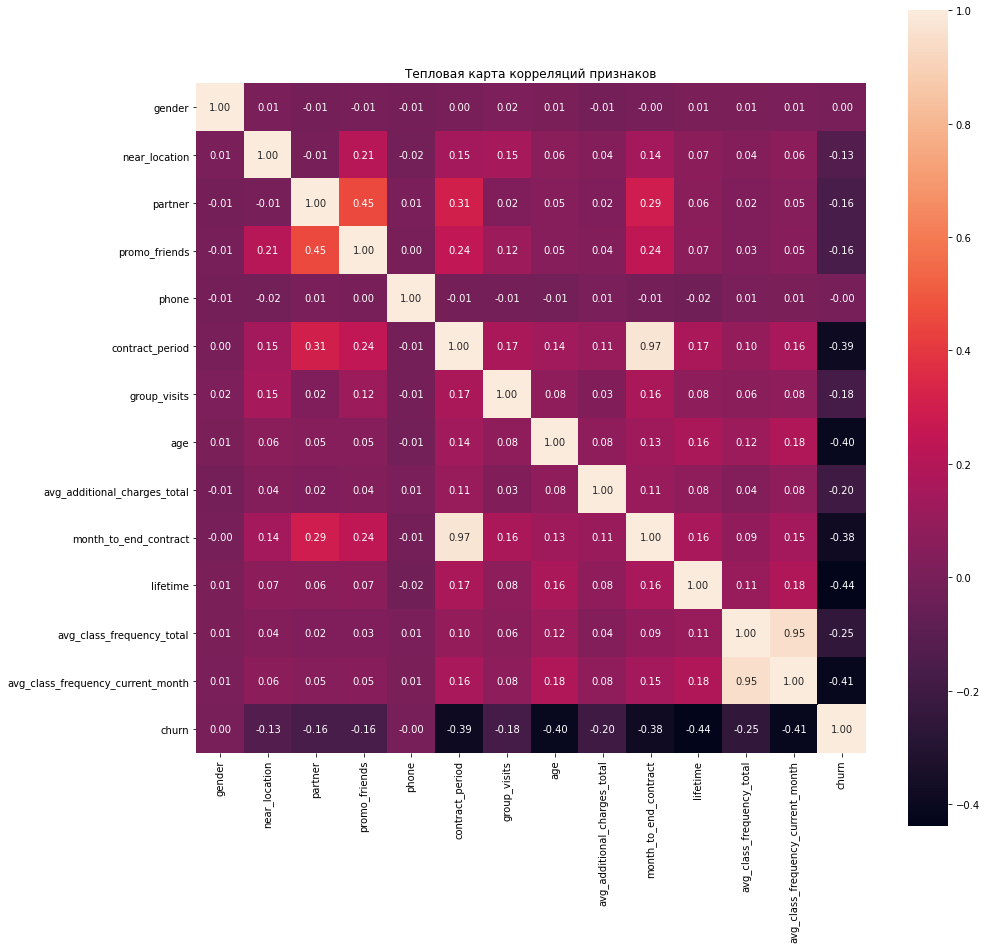

In [53]:
f, ax = plt.subplots(figsize=(15,15))
corr = df.corr()
sns.heatmap(corr, annot=True, fmt='.2f', square=True, ax=ax)
plt.title('Тепловая карта корреляций признаков')
plt.show()

Отток клиентов сильно отрицательно коррелируется с временем общения с клиентом и со сроком абонемента, что впоне логично - клиенты с долгой историей и длительным абонементом менее вероятно попадут в отвал.

Кроме того, клиент часто посещающий зал с меньшей вероятностью попадет в отвал.

Остальные корреляции значительно слабее.

### Выводы
Клиент клуба это:
- мужчина или женщина в возрасте около 29 лет
- Чаще всего живет в одном районе с клубом
- Абонемент у него сроком от 1 до 6 месяцев (только четверть клиентов имеют абонемент длительностью больше 6 месяцев)
- Фитнес посещает около 2х раз в неделю
- На доп.услуги тратит от 70 до 210 (в среднем 150)
- В клуб ходит уже около 3-4 месяцев

Отток клиентов подвержен влиянию следующих признаков:
- Lifetime - чем меньше, тем выше вероятность оттока
- Частота посещения фитнес-клуба - чем чаще, тем меньше вероятность оттока
- Возраст - более молодые чаще уходят в отток
- Срок абонемента - более короткие абонементы чаще уходят в отток

В меньшей степени, но тоже влияют на отток:
- Доп. траты
- Посещение групповых занятий - чем больше посещяет, тем меньше вероятность оттока
- Расположение - если клиент живет поблизости, то вероятность оттока ниже

## Шаг 3. Модель прогнозирования оттока клиентов

### Разобьем данные на обучающую и валидационную выборку функцией train_test_split()

In [62]:
X = df.drop('churn', axis=1)
y = df['churn']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y) 
#метки целевой переменной не сбалансированы, 
#поэтому нужно использовать стратификационное разбиение - параметр stratify

In [63]:
#стандартизируем данные
scaler = StandardScaler()
X_train_st = scaler.fit_transform(X_train)
X_test_st = scaler.transform(X_test)

In [64]:
#создадим функцию для отображения метрик 
def all_metrics_show(y_true, y_pred, y_proba, title = 'Метрики'):
    print(title)
    print('\tAccuracy: {:.2f}'.format(accuracy_score(y_true, y_pred)))
    print('\tPrecision: {:.2f}'.format(precision_score(y_true, y_pred)))
    print('\tRecall: {:.2f}'.format(recall_score(y_true, y_pred)))
    print('\tF1: {:.2f}'.format(f1_score(y_true, y_pred)))

### Обучим модели

#### LogisticRegression - логистическая регрессия

In [72]:
logreg_model = LogisticRegression(solver='liblinear')
logreg_model.fit(X_train_st, y_train)

logreg_predictions = logreg_model.predict(X_test_st)
logreg_probabilities = logreg_model.predict_proba(X_test_st)[:,1]

In [73]:
all_metrics_show(y_test, logreg_predictions, logreg_probabilities, title='LogisticRegression')

LogisticRegression
	Accuracy: 0.93
	Precision: 0.88
	Recall: 0.84
	F1: 0.86


#### RandomForestClassifier - случайный лес

In [68]:
forest_model = RandomForestClassifier(n_estimators=100, random_state=0)
forest_model.fit(X_train_st, y_train)
forest_predictions = forest_model.predict(X_test_st)
forest_probabilities = forest_model.predict_proba(X_test_st)[:,1]

In [69]:
all_metrics_show(y_test, forest_predictions, forest_probabilities, title='RandomForestClassifier')

RandomForestClassifier
	Accuracy: 0.91
	Precision: 0.86
	Recall: 0.81
	F1: 0.83


Text(0.5, 1.0, 'Матрица ошибок')

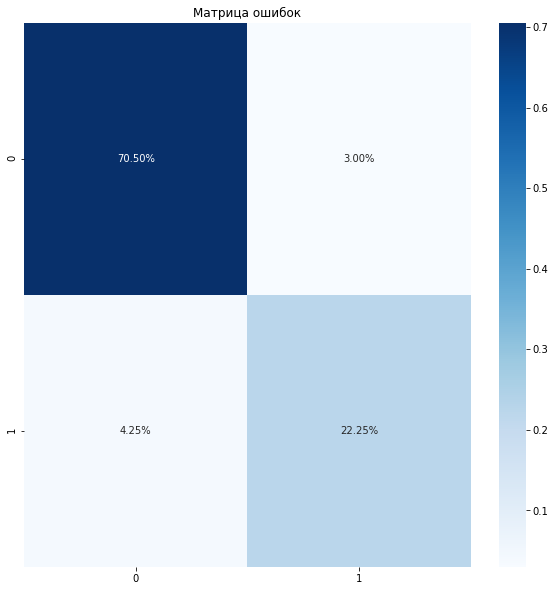

In [78]:
cf_matrix = confusion_matrix(y_test, logreg_predictions)
plt.subplots(figsize=(10,10))
sns.heatmap(cf_matrix/np.sum(cf_matrix), annot=True, 
            fmt='.2%', cmap='Blues')
plt.title('Матрица ошибок')


### Вывод
- Accuracy - доля верно угаданных ответов у логрегрессии 0,93, у случ.леса 0,91
- Precision - доля правильных ответов только среди целевого класса для логистической регрессии выше 0,88 против 0,86 (можно не ориентироваться на эту метрику - неверное предсказание оттока не стоит никаких ресурсов)
- Recall - важная метрика - показывает сколько оттока (1) мы обнаружили с помощью модели - у логистической регрессии точность выше 0,84 против 0,81
- метрика F1 выше у лог.регрессии 0,86 против 0,83

Логистическая регрессия незначительно, но более точна, чем случайный лес.

## Шаг 4. Кластеризация клиентов

In [79]:
#Построим матрицу расстояний
sc = StandardScaler()
X_sc = sc.fit_transform(X)
linked = linkage(X_sc, method='ward')

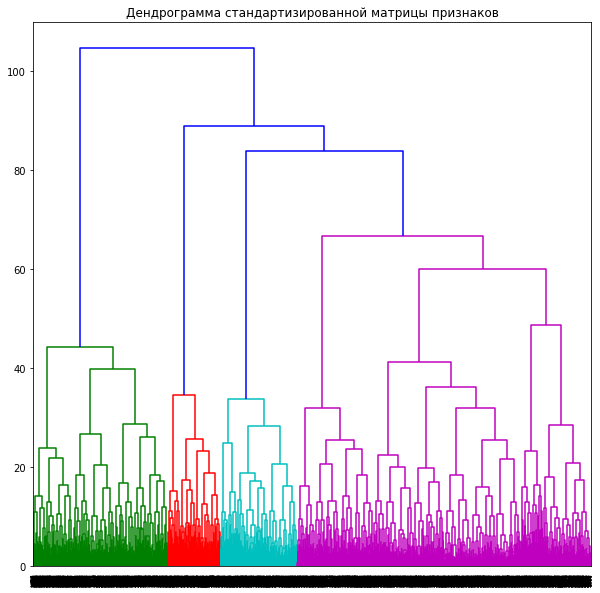

In [80]:
#построим дендрограмму
plt.figure(figsize=(10,10))
dendrogram(linked, orientation='top')
plt.title('Дендрограмма стандартизированной матрицы признаков')
plt.show()

### K-means

In [81]:
km = KMeans(n_clusters = 5, random_state=0) 

labels = km.fit_predict(X_sc) 

In [82]:
df['cluster'] = labels

In [83]:
#функция отображения каунтплота для разных кластеров
def df_cluster(column, title):
    display(df.groupby('cluster')[column].value_counts(normalize=True))
    sns.countplot(x='cluster', hue=column, data=df)
    plt.title(title)
    plt.xlabel("Кластеры")
    plt.ylabel("Кол-во")
    plt.grid(True)
    plt.show()

cluster  gender
0        1         0.522078
         0         0.477922
1        0         0.519700
         1         0.480300
2        1         0.560096
         0         0.439904
3        1         0.509603
         0         0.490397
4        0         0.504274
         1         0.495726
Name: gender, dtype: float64

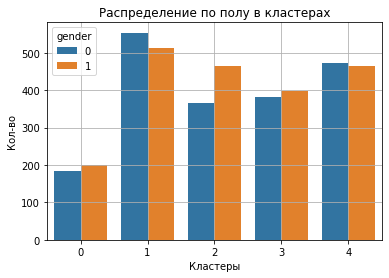

In [84]:
df_cluster('gender', "Распределение по полу в кластерах")

Мужчин и женщин практически поровну во всех кластерах.

cluster  near_location
0        1                0.862338
         0                0.137662
1        1                0.812383
         0                0.187617
2        1                0.858173
         0                0.141827
3        1                0.750320
         0                0.249680
4        1                0.943376
         0                0.056624
Name: near_location, dtype: float64

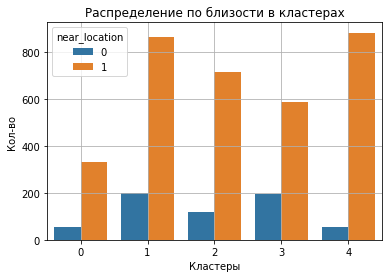

In [85]:
df_cluster('near_location', "Распределение по близости в кластерах")

Во 2м кластере все живут не в одном районе с клубом, а в 3м кластере наоборот. В 1 и 4 кластерах большинство также живет в одном районе с клубом.

cluster  partner
0        0          0.529870
         1          0.470130
1        0          1.000000
2        0          0.662260
         1          0.337740
3        1          1.000000
4        1          0.752137
         0          0.247863
Name: partner, dtype: float64

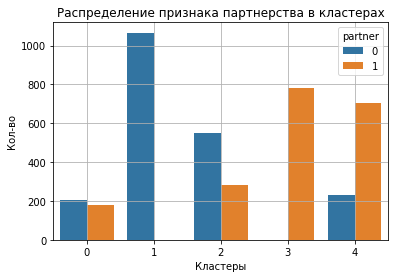

In [87]:
df_cluster('partner', "Распределение признака партнерства в кластерах")

В кластере 0 большинство клиентов из фирм-партнеров

cluster  promo_friends
0        0                0.693506
         1                0.306494
1        0                0.913696
         1                0.086304
2        0                0.802885
         1                0.197115
3        0                0.548015
         1                0.451985
4        1                0.541667
         0                0.458333
Name: promo_friends, dtype: float64

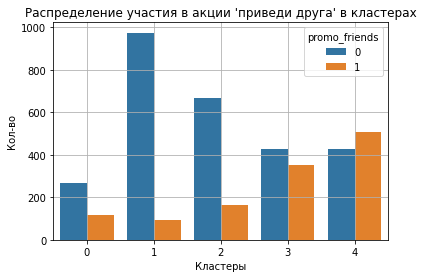

In [88]:
df_cluster('promo_friends', "Распределение участия в акции 'приведи друга' в кластерах")

В нулевом кластере большинство пришло по рекомендации друга.

cluster  phone
0        0        1.000000
1        1        1.000000
2        1        0.998798
         0        0.001202
3        1        1.000000
4        1        1.000000
Name: phone, dtype: float64

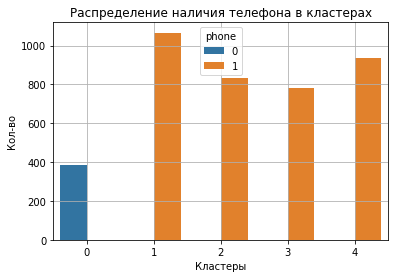

In [89]:
df_cluster('phone', "Распределение наличия телефона в кластерах")

В всех, кроме 1, кластерах у всех клиентов есть телефон.

cluster  contract_period
0        1                  0.532468
         12                 0.241558
         6                  0.225974
1        1                  0.838649
         6                  0.151970
         12                 0.009381
2        1                  0.679087
         6                  0.299279
         12                 0.021635
3        1                  0.695262
         6                  0.299616
         12                 0.005122
4        12                 0.892094
         6                  0.107906
Name: contract_period, dtype: float64

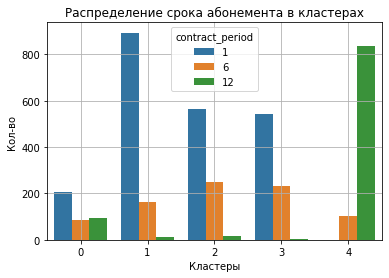

In [90]:
df_cluster('contract_period', "Распределение срока абонемента в кластерах")

В нулевом кластере все клиенты купили абонемент на 6 или 12 месяцев, в остальных кластерах большинство клиентов купили месячный абонемент.

cluster  group_visits
0        0               0.574026
         1               0.425974
1        0               0.675422
         1               0.324578
2        0               0.550481
         1               0.449519
3        0               0.696543
         1               0.303457
4        1               0.564103
         0               0.435897
Name: group_visits, dtype: float64

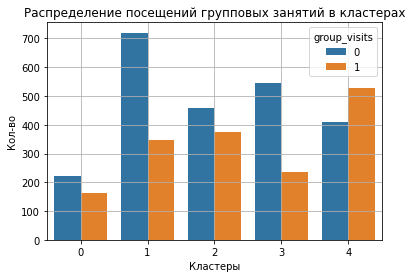

In [92]:
df_cluster('group_visits', "Распределение посещений групповых занятий в кластерах")

In [93]:
def df_cluster_qua(col, title):
    plt.figure(figsize=(10,5))
    sns.boxplot(y=col, x='cluster', data=df)
    plt.title(title)
    plt.xlabel("Кластер")
    plt.grid(True)
    plt.show()
    
    plt.figure(figsize=(10,5))
    sns.scatterplot(x='cluster', y=col, hue='churn', data=df)
    plt.title(title)
    plt.xlabel("Кластер")
    plt.legend(loc=1)
    plt.grid(True)
    plt.show()

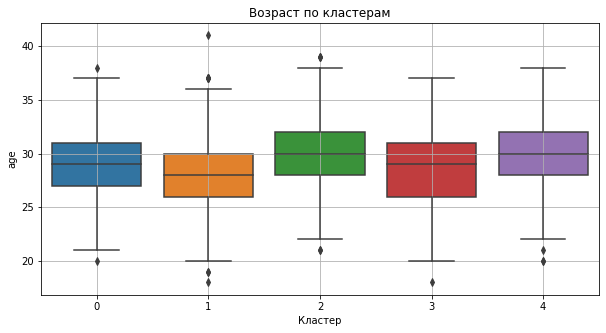

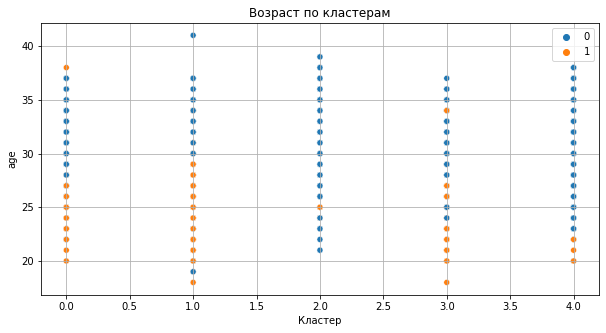

In [94]:
df_cluster_qua('age', "Возраст по кластерам")

Наибольший отток в 3 кластере, где возраст клиента в среднем ниже остальных.

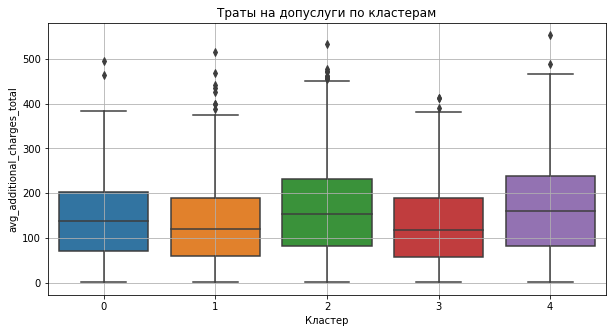

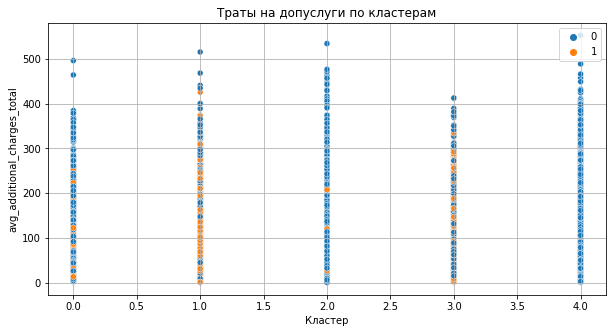

In [95]:
df_cluster_qua('avg_additional_charges_total', 'Траты на допуслуги по кластерам')

Меньшие траты у клиентов склонных к оттоку. Клиенты с большими тратами менее вероятно попадут в отток.

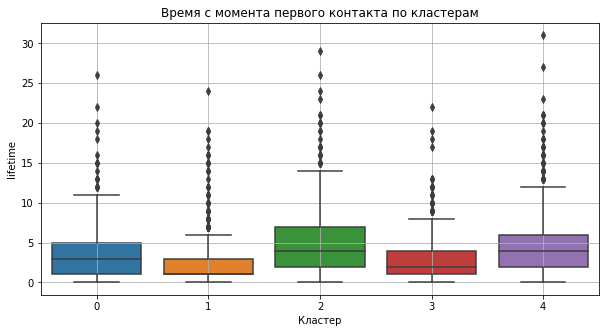

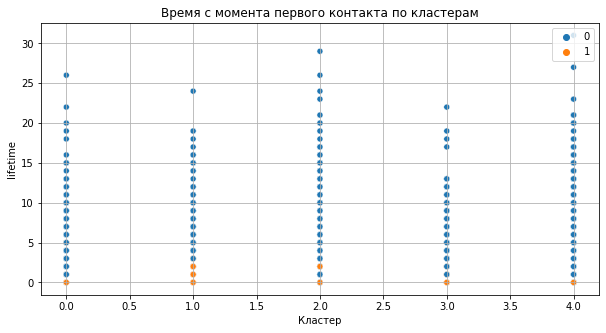

In [96]:
df_cluster_qua('lifetime', 'Время с момента первого контакта по кластерам')

Чем дольше клиент посещал клуб, тем менее вероятно отвалится.

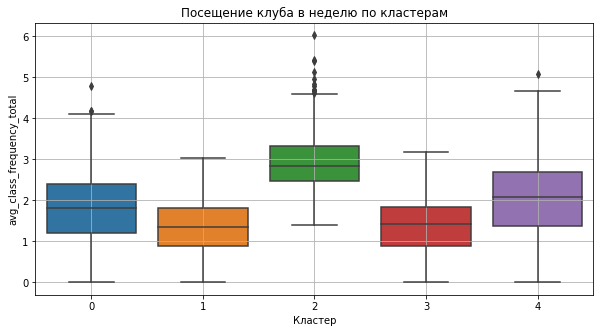

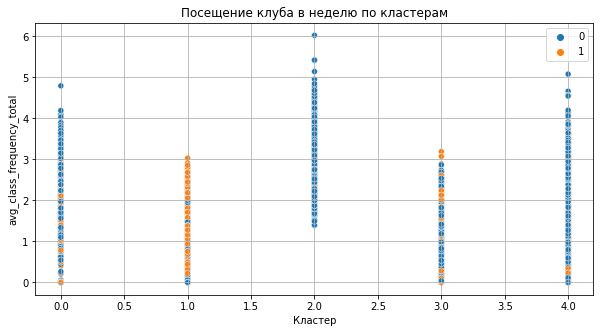

In [97]:
df_cluster_qua('avg_class_frequency_total', 'Посещение клуба в неделю по кластерам')

Меньше всего посещений в неделю у самого отвального 3 кластера.


cluster  churn
0        0        0.732468
         1        0.267532
1        1        0.550657
         0        0.449343
2        0        0.951923
         1        0.048077
3        0        0.604353
         1        0.395647
4        0        0.976496
         1        0.023504
Name: churn, dtype: float64

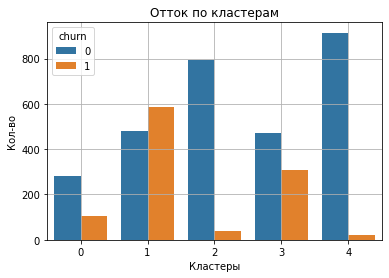

In [98]:
df_cluster('churn', 'Отток по кластерам')

Меньше всего оттока в 0 и 4 кластерах - их можно назвать самыми надежными!

### Выводы
Проведена кластеризация по методу К-средних (k-means) и алгоритм выделил 5 кластеров клиентов.
- Самый надежный кластер №0 - для клиентов здесь характерен низкий ооток, им больше лет чем остальным (в среднем 30) они занимаются по длительному абонементу (между 6 и 12 месяцами), посещают зал около 2 раз в неделю, живут в одном с клубом районе, тратят на доп услуги много.
- Кластер №4 менее надежный, но отток здесь также невысокий - это тоже люди старше (в среднем 30 лет), они пришли в клуб без рекомендаций, посещают клуб больше остальных и тратят на доп.услуги больше остальных.
- Кластер №3 самый ненадежный - здесь к оттоку склоны сильней - это самые молодые люди, с редким посещением (1 раз в неделю), и срок их абонемента 1 месяц.

## Общие выводы и рекомендации

Предсказание оттока клиентов в будущем месяце в случае с нашими данными лучше (хоть не значительно) проводить методов линейной регрессии - все метрики этого метода лучше, чем у метода случайного леса. 

Особенно важно отметить метрику recall, так как лучше спрогнощировать отток и ошибиться, чем наоборот. В этом бизнесе это важно.

Проанализированы основные признаки, влияющие на отток:
- возраст - более молодые клиенты больше склонны к оттоку
- lifetime - чем дольше тем, меньше вероятность оттока
- срок абонемента - клиенты с длительными абонементами менее склонны к оттоку
- район проживания - клиенты реже отваливаются, если живут рядом
- среднее кол-во посещений в неделю - реже 2 раз - сигнал о возможном оттоке в будущем

Рекомендации

Считаю целесообразным для клуба укреплять и наращивать партнерские связи - привлекать к сотрудничеству фирмы, которые будут отправлять на занятия своих сотрудников, это надежный источник постоянных клиентов.

Кроме того, стоит обращать внимание и поощерять клиентов из более старшей группы и тех кто чаще ходит в клуб - это надежные клиенты, их стоит беречь.

Для борьбы с отвалом стоит поработать с младшей возрастной группой, для таких клиентов возможно сделать скидки на длительные абонементы. Поощерять частые посещения (возможно дарить занятия с тренером).